# Load required packages

In [8]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# residence times

## Load data

In [9]:
# Names and location of datasets
abs_dir = os.getcwd()
rel_dir = '../../data/PHM/raw/UZG/'
name_raw_list=['MZG_2016.xlsx', 'MZG_2017.xlsx','MZG_2018.xlsx', 'MZG_2019.xlsx', 'MZG_2020.xlsx', 'MZG_2021.xlsx']
# Construct list of locations
path_list=[]
for idx,name in enumerate(name_raw_list):
    path_list.append(os.path.join(abs_dir,rel_dir,name))
# Location of results
result_folder='../../data/PHM/interim/UZG/'
result_name='MZG_residence_times.csv'
result_path = os.path.join(abs_dir,result_folder,result_name)
if not os.path.exists(os.path.join(abs_dir,result_folder)):
    os.makedirs(os.path.join(abs_dir,result_folder))
# Load datasets and merge them togheter
df = pd.concat(
    map(pd.read_excel, path_list))

In [10]:
MDC_dict = {}
keys = df['Pathologie - APR-MDC sleutel'].unique()
for key in keys:    
    name = df.loc[df['Pathologie - APR-MDC sleutel']==key].iloc[0]['Pathologie - APR-MDC naam (en)']
    MDC_dict.update({key:name})

In [11]:
keys

array(['01', '.', '06', '09', '23', '03', '00', '08', '02', '04', '12',
       '05', 'AA', '25', '22', 'PP', '16', '07', '15', '17', '21', '18',
       '19', '11', '10', '14', '13', '24', '20'], dtype=object)

In [13]:
# load csv module
import csv

# open file for writing, "w" is writing
file_name = 'MDC_dict.csv'
w = csv.writer(open(os.path.join(abs_dir,result_folder,file_name), "w",newline=''))

# loop over dictionary keys and values
for key, val in MDC_dict.items():

    # write every key and value to file
    w.writerow([key, val])

## Format data

In [7]:
# Throw out names of MDC (can look this up online)
del df['Pathologie - APR-MDC naam']
del df['Pathologie - APR-MDC naam (en)']
df.rename(columns={'Pathologie - APR-MDC sleutel': 'APR_MDC_key',
                   'MZG Opnamedatum - tekst': 'intake_date',
                   'MZG Ontslagdatum - tekst': 'discharge_date',
                   'Bezoek Opnameleeftijd per 5': 'age_group',
                   'Verblijf type - label': 'stay_type'}, inplace=True)
# Remove missing discharge dates
print('\tRemoved {0}/{1} entries due to missing discharge date'.format(len(df['discharge_date'][df['discharge_date']=='No Date']), len(df)))
df = df[df.discharge_date != 'No Date']
# Parse dates
df['intake_date'] = pd.to_datetime(df.intake_date, format='%d/%m/%Y')
df['discharge_date'] = pd.to_datetime(df.discharge_date, format='%d/%m/%Y')
# Replace stay types with their key
mapping = {'H | Klassieke hospitalisatie': 'H',
           'D | Andere daghospitalisatie': 'D',
           'C | Chirurgisch dagziekenhuis': 'C',
           'M | Tussentijdse registratie langdurig verblijf': 'M',
           'F | Eerste registratie langdurig verblijf': 'F',
           'L | Laatste registratie langdurig verblijf': 'L'}
df.stay_type=df.stay_type.map(lambda x: mapping.get(x) if x else None)
# Throw out categories M, F, L
print("\tRemoved {0}/{1} entries with stay_type 'M'".format(len(df['stay_type'][df['stay_type']=='M']), len(df)))
print("\tRemoved {0}/{1} entries with stay_type 'F'".format(len(df['stay_type'][df['stay_type']=='F']), len(df)))
print("\tRemoved {0}/{1} entries with stay_type 'L'".format(len(df['stay_type'][df['stay_type']=='L']), len(df)))
df = df[( (df.stay_type != 'L') & (df.stay_type != 'F') & (df.stay_type != 'M'))]
# Replace age categories with a simpler format
mapping={'Cat: 0 - 4': '0-4', 'Cat: 5 - 9': '5-9', 'Cat: 10 - 14': '10-14', 'Cat: 15 - 19': '15-19',
         'Cat: 20 - 24': '20-24', 'Cat: 25 - 29': '25-29', 'Cat: 30 - 34': '30-34', 'Cat: 35 - 39': '35-39',
         'Cat: 40 - 44': '40-44', 'Cat: 45 - 49': '45-49', 'Cat: 50 - 54': '50-54', 'Cat: 55 - 59': '55-59',
         'Cat: 60 - 64': '60-64', 'Cat: 65 - 69': '65-69', 'Cat: 70 - 74': '70-74', 'Cat: 75 - 79': '75-79',
         'Cat: 80 - 84': '80-84', 'Cat: 85 - 89': '85-89', 'Cat: 90 - 94': '90-94', 'Cat: 95+': '95-120'}
df.age_group=df.age_group.map(lambda x: mapping.get(x) if x else None)
# Throw out age group equal to nan
l = len(df)
df = df.dropna()
print("\tRemoved {0}/{1} entries with missing age group".format(l-len(df), l))
# Throw out missing APR-MDC classifications
print("\tRemoved {0}/{1} entries because APR-MDC classification was missing\n".format(len(df.APR_MDC_key[df.APR_MDC_key=='.']), len(df)))
df = df[df.APR_MDC_key!='.']
# Index on intake_date and sort
df = df.set_index(['APR_MDC_key', 'age_group', 'stay_type']).sort_index()
# Save lowest and highest intake date
intake_min = df.intake_date.min()
intake_max = df.intake_date.max()

	Removed 218/572253 entries due to missing discharge date
	Removed 0/572035 entries with stay_type 'M'
	Removed 0/572035 entries with stay_type 'F'
	Removed 192/572035 entries with stay_type 'L'
	Removed 164/571843 entries with missing age group
	Removed 57220/571679 entries because APR-MDC classification was missing



## Calculating residence times

In [77]:
residence_times = (df['discharge_date']-df['intake_date'])/pd.Timedelta(days=1)
mean_residence_times = df.groupby(by=['APR_MDC_key','age_group','stay_type']).apply(lambda x: (x['discharge_date'] - x['intake_date']).mean()/pd.Timedelta(days=1))

## Save result

In [78]:
residence_times.to_csv(result_path)

# hospitalizations per day

In [79]:
data = df[((df['intake_date']<pd.Timestamp('2020-01-01'))&(df['intake_date']>=pd.Timestamp('2016-01-01')))]
data = data.groupby(by='APR_MDC_key')['intake_date'].value_counts()
data.rename('hospitalizations',inplace=True)
data=pd.DataFrame(data)

data['week_number'] = pd.to_datetime(data.index.get_level_values('intake_date').values).isocalendar().week.values
data['day_number'] = pd.to_datetime(data.index.get_level_values('intake_date').values).isocalendar().day.values
hospitalizations_per_day = data.groupby(by=['APR_MDC_key','week_number','day_number']).median()
for disease in hospitalizations_per_day.index.get_level_values('APR_MDC_key').unique():
    for week in hospitalizations_per_day.index.get_level_values('week_number').unique():
        for day in hospitalizations_per_day.index.get_level_values('day_number').unique():
            try:
                hospitalizations_per_day.loc[disease,week,day]
            except:
                hospitalizations_per_day.loc[disease,week,day]=0
hospitalizations_per_day.to_csv(os.path.join(abs_dir,result_folder,'MZG_Hospitalizations_per_day.csv'))

# covid hospitalizations per day

In [80]:
data = df[((df['intake_date']>=pd.Timestamp('2020-01-01')))]
data = data.loc['04',slice(None),slice(None)]
data_count = data['intake_date'].value_counts()
data_count.rename('hospitalizations',inplace=True)
data_count=pd.DataFrame(data_count)
covid_hospitalizations = data_count.copy()
baseline = hospitalizations_per_day.loc['04',slice(None),slice(None)]
for date in data_count.index.get_level_values(0):
    week = date.isocalendar().week
    day = date.isocalendar().weekday
    if data_count.loc[date].values>baseline.loc[week,day].values:
        covid_hospitalizations.loc[date]=data_count.loc[date]-baseline.loc[week,day]
    else:
        covid_hospitalizations.loc[date]=0
covid_hospitalizations = covid_hospitalizations.sort_index()
covid_hospitalizations.to_csv(os.path.join(abs_dir,result_folder,'MZG_covid_hospitalizations_per_day.csv'))


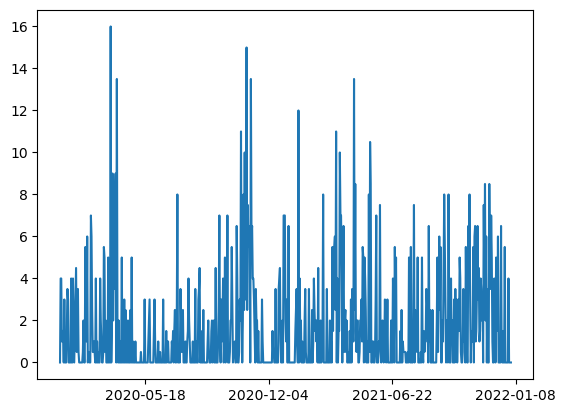

In [81]:
time = covid_hospitalizations.index.get_level_values(0)
covid = covid_hospitalizations.values
fig,ax = plt.subplots()
ax.plot(time,covid)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

# Baseline hospitalizations

In [82]:
###############
## Load data ##
###############

print('\n(1) Loading intermediate dataset\n')

# Name and location of intermediate dataset
abs_dir = os.getcwd()
rel_dir = '../../data/interim/QALY_model/postponement_non_covid_care/UZG/MZG_2016_2021.csv'
# Name and location of saved dataframe
result_folder =  '../../data/interim/QALY_model/postponement_non_covid_care/UZG/2020_2021_normalized.csv'
# Load data
df = pd.read_csv(os.path.join(abs_dir, rel_dir), index_col=[0,1,2,3], parse_dates=True)
# Sum to weekly frequency to reduce noise in the dataset
df = df.reset_index().dropna().groupby(by=['APR_MDC_key', 'date']).sum().sort_index()

############################################################
## Construct baseline dataframe using data from 2017-2019 ##
############################################################

bootstrap_repeats = 200
subset_size=5

print('\n(2) Constructing baseline dataframe using data from 2016-2020\n')

# Define a target dataframe containing the week and day number instead of the date
week_numbers = list(range(1,53+1))
day_numbers = list(range(1,7+1))
iterables=[]
names=[]
for index_name in df.index.names:
    if index_name != 'date':
        iterables += [df.index.get_level_values(index_name).unique()]
        names += [index_name,]
iterables.append(week_numbers)
iterables.append(day_numbers)
names.append('week_number')
names.append('day_number')
# Add bootstrap axis
iterables.append(list(range(bootstrap_repeats)))
names.append('bootstrap_sample')
index = pd.MultiIndex.from_product(iterables, names=names)
baseline_df = pd.Series(index=index, name='n_patients', data=np.zeros(len(index), dtype=int))
# Use all data from the jan. 2016 until jan. 2020 as baseline
baseline = df[((df.index.get_level_values('date')<pd.Timestamp('2020-01-01'))&(df.index.get_level_values('date')>=pd.Timestamp('2016-01-01')))]

names=['week_number', 'day_number']
iterables=[baseline_df.index.get_level_values('week_number').unique(), baseline_df.index.get_level_values('day_number').unique()]
index = pd.MultiIndex.from_product(iterables, names=names)
merge_df = pd.Series(index=index, name='n_patients', data=np.zeros(len(index), dtype=int))

# Loop over all possible indices, convert date to day of year, take average of values with same day-of-year number
for APR_MDC_key in baseline.index.get_level_values('APR_MDC_key').unique():
    for idx in baseline_df.index.get_level_values('bootstrap_sample').unique():
        # Extract dataseries
        data = baseline.loc[(APR_MDC_key,),:]
        # Reset index to 'unlock' the date
        data.reset_index(inplace=True)
        # Convert the date to week and day number
        data['week_number'] = pd.to_datetime(data['date'].values).isocalendar().week.values
        data['day_number'] = pd.to_datetime(data['date'].values).isocalendar().day.values
        # Perform a groupby 'date' operation with mean() to take the mean of all values with similar daynumber
        d = data.groupby(by=['week_number','day_number']).apply(lambda x: np.mean(x.sample(n=subset_size, replace=True)))['n_patients']
        baseline_df.loc[APR_MDC_key, slice(None), slice(None), idx] = pd.merge(d, merge_df, how='right', on=['week_number','day_number']).fillna(method='ffill')['n_patients_x'].values   



(1) Loading intermediate dataset



KeyboardInterrupt: 

In [ ]:
# Location of results
result_folder='../../data/interim/QALY_model/postponement_non_covid_care/UZG/'
result_name='MZG_baseline.csv'
result_path = os.path.join(abs_dir,result_folder,result_name)
baseline_df.to_csv(result_path)